<a href="https://colab.research.google.com/github/shin0105/4YP/blob/main/RF_optimizer_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install GPyOpt --quiet
!pip install GPy --quiet

In [ ]:
#import packages

#basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
import random

#Bayesian optimization packages
import GPy
import GPyOpt

#ML Algorithm packages
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import preprocessing

from scipy.optimize import minimize

In [ ]:
#dataset = UCI Car Evaluation
names=['buying','maint','doors','persons','lug_boot','safety','class']
df = pd.read_csv('car.data', names = names)
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [ ]:
#Convert categorical labels to numbers
le = preprocessing.LabelEncoder()

for col in names: 
  df[col] = le.fit_transform(df[col])

In [ ]:
X = df.drop(['class'], axis=1)
y = df['class']

#splitting train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
#K-fold validation
def kfold_score(clf,X,y,n_fold):
    X,y = X.values,y.values
    kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds,y_test_fold)
        accuracy_list.append(accuracy_test)
    return np.array(accuracy_list).mean()

In [ ]:
#Random Forest classification

#max_features: 1 to around sqrt(# of features of dataset)
bounds = [
        {'name': 'max_features', 'type': 'continuous', 'domain': (1, 5)},
        {'name': 'n_estimators', 'type': 'continuous', 'domain': (1, 200)}
      ]

def rf_score(parameters):
  params = {
        'max_features':int(parameters[0][0]),
        'n_estimators':int(parameters[0][1])
    }
  
  clf = RandomForestClassifier(max_features=params['max_features'],n_estimators=params['n_estimators'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,5)
  return score

In [ ]:
kernel1 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=2.304,active_dims=[0])
kernel2 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=0.361,active_dims=[1])
kernel3 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=2.304,active_dims=[0]) \
          * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=0.361,active_dims=[1])
kernel = kernel1 + kernel2 + kernel3

In [ ]:
optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
optimizer.run_optimization(max_iter=20)

X=(optimizer.X)
m, v = optimizer.model.predict(X)
log_mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
        -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))
print(log_mll)

[[-0.75180686]]


In [ ]:
a=0.1
kernel1 = GPy.kern.Matern52(input_dim=1,variance=a,lengthscale=1.724,active_dims=[0])
kernel2 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=2.072,active_dims=[1])
kernel3 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1.724,active_dims=[0]) \
          * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=2.072,active_dims=[1])
kernel = kernel1 + kernel2 + kernel3

optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
optimizer.run_optimization(max_iter=20)

X=(optimizer.X)
m, v = optimizer.model.predict(X)
log_mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
        -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))

for i in range (20):
  a=a+0.1

  kernel1 = GPy.kern.Matern52(input_dim=1,variance=a,lengthscale=1.724,active_dims=[0])
  kernel2 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=2.072,active_dims=[1])
  kernel3 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1.724,active_dims=[0]) \
          * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=2.072,active_dims=[1])
  kernel = kernel1 + kernel2 + kernel3

  dKda = GPy.kern.Matern52(input_dim=1,variance=np.sqrt(2*a),lengthscale=2.304,active_dims=[0])

  optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
  optimizer.run_optimization(max_iter=20)
  X=(optimizer.X)
  m, v = optimizer.model.predict(X)

  V = kernel.K(X,X)+(0.01**2)*np.identity(25)
  alpha = np.matmul(np.linalg.inv(V), optimizer.Y - m)
  dLda = 0.5*(np.matmul(np.matmul(alpha.T,dKda.K(X,X)),alpha) - np.trace(np.matmul(np.linalg.inv(V),dKda.K(X,X))))
  log_mll = log_mll + 0.1*dLda
  mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
        -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))
  print(f"log mll by gradient {log_mll}, gradient {dLda}, actual log mll {mll}")

log mll by gradient [[18.67502238]], gradient [[0.21780046]], actual log mll [[13.74136793]]
log mll by gradient [[18.66575559]], gradient [[-0.09266786]], actual log mll [[20.73620134]]
log mll by gradient [[18.67454499]], gradient [[0.08789398]], actual log mll [[51.64340142]]
log mll by gradient [[18.55138876]], gradient [[-1.23156229]], actual log mll [[35.85655115]]
log mll by gradient [[18.54531998]], gradient [[-0.06068786]], actual log mll [[54.87946645]]
log mll by gradient [[18.56600757]], gradient [[0.20687595]], actual log mll [[8.94291955]]
log mll by gradient [[19.57472505]], gradient [[10.08717477]], actual log mll [[2.34661925]]
log mll by gradient [[19.7729812]], gradient [[1.98256152]], actual log mll [[-3.39100129]]
log mll by gradient [[19.76624854]], gradient [[-0.0673266]], actual log mll [[8.13559338]]
log mll by gradient [[19.76689778]], gradient [[0.00649242]], actual log mll [[3.59295482]]
log mll by gradient [[21.19575431]], gradient [[14.28856526]], actual l

In [ ]:
b=0.1
kernel1 = GPy.kern.Matern52(input_dim=1,variance=1.8,lengthscale=1.724,active_dims=[0])
kernel2 = GPy.kern.Matern52(input_dim=1,variance=b,lengthscale=2.072,active_dims=[1])
kernel3 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1.724,active_dims=[0]) \
          * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=2.072,active_dims=[1])
kernel = kernel1 + kernel2 + kernel3

optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
optimizer.run_optimization(max_iter=20)

X=(optimizer.X)
m, v = optimizer.model.predict(X)
log_mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
        -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))

for i in range (20):
  b=b+0.1

  kernel1 = GPy.kern.Matern52(input_dim=1,variance=1.8,lengthscale=1.724,active_dims=[0])
  kernel2 = GPy.kern.Matern52(input_dim=1,variance=b,lengthscale=2.072,active_dims=[1])
  kernel3 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1.724,active_dims=[0]) \
          * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=2.072,active_dims=[1])
  kernel = kernel1 + kernel2 + kernel3

  optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
  optimizer.run_optimization(max_iter=20)
  X=(optimizer.X)
  m, v = optimizer.model.predict(X)

  mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
        -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))
  print(f"actual log mll {mll}")

actual log mll [[24.70064452]]
actual log mll [[8.05359727]]
actual log mll [[20.34756473]]
actual log mll [[16.1916133]]
actual log mll [[-3.83837325]]
actual log mll [[45.30778499]]
actual log mll [[27.65665177]]
actual log mll [[22.20746718]]
actual log mll [[6.23083525]]
actual log mll [[26.19039719]]
actual log mll [[16.05892655]]
actual log mll [[30.39869836]]
actual log mll [[10.94356066]]
actual log mll [[14.72895135]]
actual log mll [[-6.52609453]]
actual log mll [[10.48099976]]
actual log mll [[6.67798533]]
actual log mll [[-8.10355217]]
actual log mll [[4.1745958]]
actual log mll [[5.57816831]]


In [ ]:
c=0.1
kernel1 = GPy.kern.Matern52(input_dim=1,variance=1.8,lengthscale=1.724,active_dims=[0])
kernel2 = GPy.kern.Matern52(input_dim=1,variance=0.7,lengthscale=2.072,active_dims=[1])
kernel3 = GPy.kern.Matern52(input_dim=1,variance=c,lengthscale=1.724,active_dims=[0]) \
          * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=2.072,active_dims=[1])
kernel = kernel1 + kernel2 + kernel3

optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
optimizer.run_optimization(max_iter=20)

X=(optimizer.X)
m, v = optimizer.model.predict(X)
log_mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
        -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))

for i in range (20):
  c=c+0.1

  kernel1 = GPy.kern.Matern52(input_dim=1,variance=1.8,lengthscale=1.724,active_dims=[0])
  kernel2 = GPy.kern.Matern52(input_dim=1,variance=0.7,lengthscale=2.072,active_dims=[1])
  kernel3 = GPy.kern.Matern52(input_dim=1,variance=c,lengthscale=1.724,active_dims=[0]) \
          * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=2.072,active_dims=[1])
  kernel = kernel1 + kernel2 + kernel3


  optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
  optimizer.run_optimization(max_iter=20)
  X=(optimizer.X)
  m, v = optimizer.model.predict(X)


  mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
        -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))
  print(f"log mll {mll}")

log mll [[23.00786976]]
log mll [[15.02616386]]
log mll [[18.35834232]]
log mll [[13.41533129]]
log mll [[8.24073597]]
log mll [[12.01250179]]
log mll [[16.59050416]]
log mll [[23.05959361]]
log mll [[36.18409071]]
log mll [[41.66290543]]
log mll [[8.07952946]]
log mll [[20.75046259]]
log mll [[9.3886804]]
log mll [[46.02501573]]
log mll [[12.25331041]]
log mll [[11.68793089]]
log mll [[11.48942474]]
log mll [[7.94350897]]
log mll [[9.24743139]]
log mll [[19.70221079]]


In [ ]:
kernel1 = GPy.kern.Matern52(input_dim=1,variance=1.8,lengthscale=1.724,active_dims=[0])
kernel2 = GPy.kern.Matern52(input_dim=1,variance=0.7,lengthscale=2.072,active_dims=[1])
kernel3 = GPy.kern.Matern52(input_dim=1,variance=1.5,lengthscale=1.724,active_dims=[0]) \
        * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=2.072,active_dims=[1])
kernel = kernel1 + kernel2 + kernel3


optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                            domain=bounds,
                                            acquisition_type ='EI',
                                            initial_design_numdata = 5,
                                            model_type='GP',
                                            maximize=True,
                                            kernel=kernel
                                            )
optimizer.run_optimization(max_iter=20)
X=(optimizer.X)
m, v = optimizer.model.predict(X)


mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
      -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))
print(f"log mll {mll}")

log mll [[30.88945231]]


In [ ]:
a=1.8
kernel1 = GPy.kern.Matern52(input_dim=1,variance=a,lengthscale=1.724,active_dims=[0])
kernel2 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=2.072,active_dims=[1])
kernel3 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1.724,active_dims=[0]) \
          * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=2.072,active_dims=[1])
kernel = kernel1 + kernel2 + kernel3

optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
optimizer.run_optimization(max_iter=20)

X=(optimizer.X)
m, v = optimizer.model.predict(X)
log_mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
        -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))

for i in range (20):
  a=a+0.1

  kernel1 = GPy.kern.Matern52(input_dim=1,variance=a,lengthscale=1.724,active_dims=[0])
  kernel2 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=2.072,active_dims=[1])
  kernel3 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1.724,active_dims=[0]) \
          * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=2.072,active_dims=[1])
  kernel = kernel1 + kernel2 + kernel3


  optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
  optimizer.run_optimization(max_iter=20)
  X=(optimizer.X)
  m, v = optimizer.model.predict(X)


  mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
        -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))
  print(f"log mll {mll}")

log mll [[8.83058536]]
log mll [[-1.4114498]]
log mll [[36.39111019]]
log mll [[65.57276834]]
log mll [[57.18723464]]
log mll [[2.68641959]]
log mll [[4.93482168]]
log mll [[6.33786892]]
log mll [[17.20009193]]
log mll [[17.82449856]]
log mll [[1.22127609]]
log mll [[21.92234817]]
log mll [[12.50549411]]
log mll [[14.17611472]]
log mll [[7.27473455]]
log mll [[11.98248328]]
log mll [[54.53132978]]
log mll [[19.64626978]]
log mll [[18.75587603]]
log mll [[60.2008362]]


In [ ]:
a=3.7
kernel1 = GPy.kern.Matern52(input_dim=1,variance=a,lengthscale=1.724,active_dims=[0])
kernel2 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=2.072,active_dims=[1])
kernel3 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1.724,active_dims=[0]) \
          * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=2.072,active_dims=[1])
kernel = kernel1 + kernel2 + kernel3

optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
optimizer.run_optimization(max_iter=20)

X=(optimizer.X)
m, v = optimizer.model.predict(X)
log_mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
        -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))

for i in range (20):
  a=a+0.1

  kernel1 = GPy.kern.Matern52(input_dim=1,variance=a,lengthscale=1.724,active_dims=[0])
  kernel2 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=2.072,active_dims=[1])
  kernel3 = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1.724,active_dims=[0]) \
          * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=2.072,active_dims=[1])
  kernel = kernel1 + kernel2 + kernel3


  optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
  optimizer.run_optimization(max_iter=20)
  X=(optimizer.X)
  m, v = optimizer.model.predict(X)


  mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
        -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))
  print(f"log mll {mll}")

log mll [[3.16349842]]
log mll [[6.62187982]]
log mll [[10.92185173]]
log mll [[9.54537848]]
log mll [[11.19961223]]
log mll [[17.10837057]]
log mll [[9.26555061]]
log mll [[24.29794283]]
log mll [[-1.99763586]]
log mll [[8.79957928]]
log mll [[14.12159838]]
log mll [[-12.41554257]]
log mll [[5.39953044]]
log mll [[4.55661649]]
log mll [[16.98425706]]
log mll [[16.87645924]]
log mll [[22.03140927]]
log mll [[17.44019778]]
log mll [[-3.43676369]]
log mll [[8.87138316]]


In [ ]:
kernel1 = GPy.kern.Matern52(input_dim=1,variance=1.8,lengthscale=1.724,active_dims=[0])
kernel2 = GPy.kern.Matern52(input_dim=1,variance=0.7,lengthscale=2.072,active_dims=[1])
kernel3 = GPy.kern.Matern52(input_dim=1,variance=1.5,lengthscale=1.724,active_dims=[0]) \
        * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=2.072,active_dims=[1])
kernel = kernel1 + kernel2 + kernel3


optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                            domain=bounds,
                                            acquisition_type ='EI',
                                            initial_design_numdata = 5,
                                            model_type='GP',
                                            maximize=True,
                                            kernel=kernel
                                            )
optimizer.run_optimization(max_iter=20)
X=(optimizer.X)
m, v = optimizer.model.predict(X)


mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
      -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))
print(f"log mll {mll}")

log mll [[76.45898779]]


<Axes: >

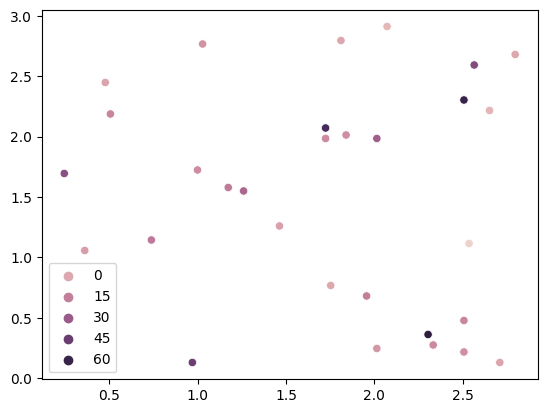

In [ ]:
l1=[2.072,1.753,0.361,1.173,0.477,1.811,1.724,2.507,2.565,1.463,1.26,2.014,2.507,1.724,2.7969999999999997,
   0.9699999999999999,2.71,2.6519999999999997,2.014,2.536,2.304,2.507,0.245,1.028,2.3329999999999997,1.8399999999999999,0.506,0.7379999999999999,
   0.9989999999999999,1.956]
l2=[2.913,0.7669999999999999,1.057,1.579,2.449,2.7969999999999997,2.072,0.477,2.594,1.26,1.55,1.9849999999999999,
    2.304,1.9849999999999999,2.681,0.129,0.129,2.217,0.245,1.115,0.361,0.216,1.695,2.768,
    0.274,2.014,2.188,1.1440000000000001,1.724,0.6799999999999999]
mll=[-5.4090463,-0.49356598,3.80974492,16.33640354,1.71432653,0.84616946,54.97415783,11.96018802,37.26561077,
     2.86872855,24.34740288,27.86286008,59.75321257,10.61102236,0.13844341,44.03325657,1.16476191,-4.47027069,
     5.73547299,-14.28301788,63.45799722,8.22819776,35.07772971,7.16100087,10.60579778,9.38131343,13.02192667,
     17.02160038,9.52288739,14.75645887]

sns.scatterplot(x=l1,y=l2,hue=mll)

In [ ]:
for i in range(30):
  l1_=random.choice(l1)
  l2_=random.choice(l2)

  kernel1 = GPy.kern.Matern52(input_dim=1,lengthscale=l1_,active_dims=[0])
  kernel2 = GPy.kern.Matern52(input_dim=1,lengthscale=l2_,active_dims=[1])
  kernel3 = GPy.kern.Matern52(input_dim=1,lengthscale=l1_,active_dims=[0]) \
          * GPy.kern.Matern52(input_dim=1,lengthscale=l2_,active_dims=[1])
  kernel = kernel1 + kernel2 + kernel3
  mll = BO(rf_score,kernel)
  print("l1 =", l1_, "l2 =", l2_, "mll =", mll)

l1 = 2.072 l2 = 2.913 mll = [[-5.4090463]]
l1 = 1.753 l2 = 0.7669999999999999 mll = [[-0.49356598]]
l1 = 0.361 l2 = 1.057 mll = [[3.80974492]]
l1 = 1.173 l2 = 1.579 mll = [[16.33640354]]
l1 = 0.477 l2 = 2.449 mll = [[1.71432653]]
l1 = 1.811 l2 = 2.7969999999999997 mll = [[0.84616946]]
l1 = 1.724 l2 = 2.072 mll = [[54.97415783]]
l1 = 2.507 l2 = 0.477 mll = [[11.96018802]]
l1 = 2.565 l2 = 2.594 mll = [[37.26561077]]
l1 = 1.463 l2 = 1.26 mll = [[2.86872855]]
l1 = 1.26 l2 = 1.55 mll = [[24.34740288]]
l1 = 2.014 l2 = 1.9849999999999999 mll = [[27.86286008]]
l1 = 2.507 l2 = 2.304 mll = [[59.75321257]]
l1 = 1.724 l2 = 1.9849999999999999 mll = [[10.61102236]]
l1 = 2.7969999999999997 l2 = 2.681 mll = [[0.13844341]]
l1 = 0.9699999999999999 l2 = 0.129 mll = [[44.03325657]]
l1 = 2.71 l2 = 0.129 mll = [[1.16476191]]
l1 = 2.6519999999999997 l2 = 2.217 mll = [[-4.47027069]]
l1 = 2.014 l2 = 0.245 mll = [[5.73547299]]
l1 = 2.536 l2 = 1.115 mll = [[-14.28301788]]
l1 = 2.304 l2 = 0.361 mll = [[63.4579972

In [ ]:
def BO(model,kernel):
  optimizer = GPyOpt.methods.BayesianOptimization(f=model, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )
  optimizer.run_optimization(max_iter=20)

  X=(optimizer.X)
  m, v = optimizer.model.predict(X)
  log_mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
          -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25))) - np.size(X_train) * 0.5 * np.log(2*np.pi)
  return log_mll

In [ ]:
score_rf=[]
v1_list=[]
l1_list=[]
v2_list=[]
l2_list=[]

for i in range(30):
  v1_=random.choice(v1)
  v1_list.append(v1_)
  l1_=random.choice(l1)
  l1_list.append(l1_)
  v2_=random.choice(v2)
  v2_list.append(v2_)
  l2_=random.choice(l2)
  l2_list.append(l2_)

  kernel1 = GPy.kern.Matern52(input_dim=1,variance=v1_,lengthscale=l1_,active_dims=[0])
  kernel2 = GPy.kern.Matern52(input_dim=1,variance=v2_,lengthscale=l2_,active_dims=[1])
  kernel3 = GPy.kern.Matern52(input_dim=1,variance=v1_,lengthscale=l1_,active_dims=[0]) \
          * GPy.kern.Matern52(input_dim=1,variance=v2_,lengthscale=l2_,active_dims=[1])
  kernel = kernel1 + kernel2 + kernel3
  mll = BO(rf_score,kernel)
  score_rf.append(mll)

  print("v1 =", v1_, "l1 =", l1_, "v2 =", v2_, "l2 =", l2_, "mll =", mll)

v1 = 1.27 l1 = 1.3900000000000001 v2 = 1.44 l2 = 0.8200000000000001 mll = [[11.64043728]]
v1 = 0.87 l1 = 0.62 v2 = 0.6799999999999999 l2 = 1.3399999999999999 mll = [[3.54728323]]
v1 = 0.62 l1 = 1.4500000000000002 v2 = 0.73 l2 = 1.23 mll = [[3.02665051]]
v1 = 1.1 l1 = 1.0 v2 = 1.21 l2 = 0.6 mll = [[10.97874664]]
v1 = 1.27 l1 = 0.98 v2 = 1.21 l2 = 0.78 mll = [[19.38325669]]
v1 = 1.38 l1 = 1.03 v2 = 0.55 l2 = 1.06 mll = [[55.79627004]]
v1 = 1.27 l1 = 0.87 v2 = 1.02 l2 = 1.06 mll = [[32.7634212]]
v1 = 0.62 l1 = 1.19 v2 = 1.49 l2 = 1.03 mll = [[14.2548648]]
v1 = 0.59 l1 = 1.26 v2 = 1.0 l2 = 1.44 mll = [[2.53304514]]
v1 = 0.55 l1 = 0.81 v2 = 0.61 l2 = 0.55 mll = [[5.47411696]]
v1 = 1.22 l1 = 0.67 v2 = 0.96 l2 = 1.47 mll = [[45.72970394]]
v1 = 1.35 l1 = 0.54 v2 = 1.1 l2 = 0.64 mll = [[38.98716722]]
v1 = 0.6799999999999999 l1 = 0.88 v2 = 0.8400000000000001 l2 = 0.8 mll = [[2.37304338]]
v1 = 1.47 l1 = 1.13 v2 = 0.79 l2 = 0.86 mll = [[-4.05377273]]
v1 = 0.71 l1 = 0.97 v2 = 1.35 l2 = 0.61 mll = [

In [ ]:
kernel1 = GPy.kern.Matern52(input_dim=1,variance=1.38,lengthscale=1.03,active_dims=[0])
kernel2 = GPy.kern.Matern52(input_dim=1,variance=0.55,lengthscale=1.06,active_dims=[1])
kernel3 = GPy.kern.Matern52(input_dim=1,variance=1.38,lengthscale=1.03,active_dims=[0]) \
         * GPy.kern.Matern52(input_dim=1,variance=0.55,lengthscale=1.06,active_dims=[1])
kernel = kernel1 + kernel2 + kernel3